## Neural networks for segmentation

In [0]:
! wget https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0 -O data.zip
! unzip -q data.zip

--2019-04-30 20:39:41--  https://www.dropbox.com/s/jy34yowcf85ydba/data.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/jy34yowcf85ydba/data.zip [following]
--2019-04-30 20:39:41--  https://www.dropbox.com/s/raw/jy34yowcf85ydba/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc5709e2052d82f12eca48d23edc.dl.dropboxusercontent.com/cd/0/inline/AgDfpEAppQGyojed0WKosqy_3KfzGD5vOz4Gv6T5kGd_K_8TRcAaHzzZMq6bnuNTTOCn3-XJuu6vbkSGaXpRE4mE7tdGK6lQLI-mtgAQx52YEQ/file# [following]
--2019-04-30 20:39:42--  https://uc5709e2052d82f12eca48d23edc.dl.dropboxusercontent.com/cd/0/inline/AgDfpEAppQGyojed0WKosqy_3KfzGD5vOz4Gv6T5kGd_K_8TRcAaHzzZMq6bnuNTTOCn3-XJuu6vbkSGaXpRE4mE7tdGK6lQLI-mtgAQx52YEQ/file
Resolving uc5709e2052d8

Your next task is to train neural network to segment cells edges.

Here is an example of input data with corresponding ground truth:

In [0]:
import scipy as sp
import scipy.misc
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


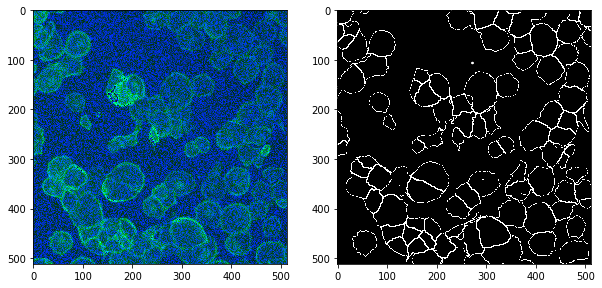

In [0]:
# Human HT29 colon-cancer cells
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
im = sp.misc.imread('BBBC018_v1_images-fixed/train/00735-actin.DIB.bmp')
plt.imshow(im)
plt.subplot(1,2,2)
mask = sp.misc.imread('BBBC018_v1_outlines/train/00735-cells.png')
plt.imshow(mask, 'gray')

In [0]:
im.shape

(512, 512, 3)

In [0]:
im = im / 255.0
im.dtype

dtype('float64')

In [0]:
mask.shape

(512, 512)

In [0]:
mask.max()

255

This time you aren't provided with any code snippets, just input data and target metric - intersection-over-union (IoU) (see implementation below).

You should train neural network to predict mask of edge pixels (pixels in gt images with value greater than 0).

Use everything you've learnt by now: 
* any architectures for semantic segmentation (encoder-decoder like or based on dilated convolutions)
* data augmentation (you will need that since train set consists of just 41 images)
* fine-tuning

You're not allowed to do only one thing: to train you network on test set.

Your final solution will consist of an ipython notebook with code (for final network training + any experiments with data) and an archive with png images with network predictions for test images (one-channel images, 0 - for non-edge pixels, any non-zero value for edge pixels).

Forestalling questions about baseline... well, let's say that a good network should be able to segment images with iou >= 0.29. This is not a strict criterion of full points solution, but try to obtain better numbers.

Practical notes:
* There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for "edge" class, or add class weights to increase the cost of edge pixels in optimized loss.
* Dataset is small so actively use data augmentation: rotations, flip, random contrast and brightness
* Better spend time on experiments with neural network than on postprocessing tricks (i.e test set augmentation).
* Keep in mind that network architecture defines receptive field of pixel. If the size of network input is smaller than receptive field of output pixel, than probably you can throw some layers without loss of quality. It is ok to modify "of-the-shelf" architectures. 

Good luck!

In [0]:
def calc_iou(prediction, ground_truth):
  
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / union

# Encoder-Decoder based

In [0]:
## check if there is a connection to GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
import os
import random
from random import randint
import shutil

from multiprocessing.dummy import Pool

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.externals import joblib

from skimage.morphology import binary_opening, disk, label


import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

import torchvision.transforms as transforms

import glob

In [0]:

# this class corresponds to view-function and may be used as a reshape layer 
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(1, input.size(0))

In [0]:
class ImgDataset(Dataset):

    def __init__(self, image_path, mask_path, img_transform, mask_transform):
        """
        Args:
            image_path (str): the path where the image is located
            mask_path (str): the path where the mask is located
            option (str): decide which dataset to import
        """
        # all file names
        self.mask_arr = glob.glob(str(mask_path) + "/*")
        self.image_arr = glob.glob(str(image_path) + str("/*"))
#         self.in_size, self.out_size = in_size, out_size
        self.data_len = len(self.mask_arr)
        self.img_transform = img_transform
        self.mask_transform = mask_transform

    def __getitem__(self, index):
        """Get specific data corresponding to the index
        Args:
            index (int): index of the data
        Returns:
            Tensor: specific data on index which is converted to Tensor
        """
        """
        # GET IMAGE
        """
        single_image_name = self.image_arr[index]  
        img_as_img = Image.open(single_image_name)
        
        if self.img_transform is not None:
          random.seed(42)
          img_as_img = self.img_transform(img_as_img)
        
        
        img_as_np = np.asarray(img_as_img)
        
        # Normalize image to be between 0 and 1
        img_as_np = img_as_np/255.0
        img_as_tensor = torch.FloatTensor(img_as_np)  # Convert numpy array to tensor

        """
        # GET MASK
        """
        single_mask_name = self.mask_arr[index]
        msk_as_img = Image.open(single_mask_name)
        
        if self.mask_transform is not None:
          random.seed(42)
          msk_as_img = self.mask_transform(msk_as_img)
          
          
        msk_as_np = np.asarray(msk_as_img)

        # mask is already 0 or 1
        msk_as_np = msk_as_np / 1.
#         msk_as_tensor = torch.FloatTensor(msk_as_np)
        return (img_as_img, msk_as_np)

    def __len__(self):
        """
        Returns:
            length (int): length of the data
        """
        return self.data_len

In [0]:
class ImgDataset_test(Dataset):

    def __init__(self, image_path, img_transform):
        """
        Args:
            image_path (str): the path where the image is located
            mask_path (str): the path where the mask is located
            option (str): decide which dataset to import
        """
        # all file names

        self.image_arr = glob.glob(str(image_path) + str("/*"))
        self.data_len = len(self.image_arr)
        self.img_transform = img_transform


    def __getitem__(self, index):
        """Get specific data corresponding to the index
        Args:
            index (int): index of the data
        Returns:
            Tensor: specific data on index which is converted to Tensor
        """
        """
        # GET IMAGE
        """
        single_image_name = self.image_arr[index]  
        img_as_img = Image.open(single_image_name)
        
        if self.img_transform is not None:
          random.seed(42)
          img_as_img = self.img_transform(img_as_img)
        
        
        img_as_np = np.asarray(img_as_img)
        
        # Normalize image to be between 0 and 1
        img_as_np = img_as_np/255.0
        img_as_tensor = torch.FloatTensor(img_as_np)  # Convert numpy array to tensor

        return img_as_img

    def __len__(self):
        """
        Returns:
            length (int): length of the data
        """
        return self.data_len

In [0]:

## 'BBBC018_v1_outlines/train/    -   path for mask
train_img_path = 'BBBC018_v1_images-fixed/train'
train_mask_path = 'BBBC018_v1_outlines/train'

val_img_path = 'BBBC018_v1_images-fixed/val'
val_mask_path = 'BBBC018_v1_outlines/val'

test_img_path = 'BBBC018_v1_images-fixed/test/'


bst_model_fpath = 'model/bst_unet.model'

original_img_size = (512, 512)


# To make image between 0 and 1
# channel_means = np.array([0.0, 0.0, 0.0])
# channel_stds = np.array([255.0, 255.0, 255.0])

train_tfms = transforms.Compose([ #transforms.Resize(param.img_size),
                                 transforms.RandomRotation(90),
                                 transforms.ToTensor()])

val_tfms = transforms.Compose([transforms.ToTensor()])
test_tfms = transforms.Compose([transforms.ToTensor()])


mask_tfms = transforms.Compose([#transforms.Resize(param.img_size),
                                transforms.RandomRotation(90),
                                transforms.ToTensor()])





### Use defined transfoms in DataLoader
train_dl = DataLoader(ImgDataset(train_img_path, 
                                 train_mask_path,
                                 train_tfms,
                                 mask_tfms),
                      batch_size=4,
                      shuffle=True)

val_dl = DataLoader(ImgDataset(val_img_path, 
                               val_mask_path,
                               val_tfms,
                               mask_tfms),
                    batch_size=4,
                    shuffle=False)

test_dl = DataLoader(ImgDataset_test(test_img_path,
                                    test_tfms),
                    batch_size=1,
                    shuffle=False)

In [0]:
model = nn.Sequential(
                                  nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size=5, padding = 2),
                                  nn.ReLU(),
                                  nn.AvgPool2d(kernel_size = 3, stride = 2, padding = 1),
                                  nn.Conv2d(16, 64, kernel_size=3, padding = 1),
                                  nn.ReLU(),
                                  nn.AvgPool2d(kernel_size = 3, stride = 2, padding = 1),
#                                    ###
                                  nn.ConvTranspose2d(64, 16, kernel_size = 4, stride = 2, padding = 1),
                                  nn.ReLU(),
                                  nn.ConvTranspose2d(16, 8, kernel_size = 4, stride = 2, padding = 1),
                                  nn.Conv2d(8, 1, kernel_size=1),   # создаем маску (1х512х512)
                                  nn.Sigmoid()        # all pixels are between 0 and 1  (apply sigmoid pixel-wise)
                                )       
model = model.cuda()

### Debug the sizes

In [0]:
for i, (X, y) in enumerate(train_dl):
  print(X.shape)
  print(model(X.cuda()).shape)
  print(y.shape)
  break

torch.Size([4, 3, 512, 512])
torch.Size([4, 1, 512, 512])
torch.Size([4, 1, 512, 512])


In [0]:
# def compute_loss(X_batch, y_batch):
#     X_batch = Variable(torch.FloatTensor(X_batch)).cuda()  
# #     y_batch = Variable(torch.LongTensor(y_batch)).cuda()
# #     y_batch = torch.Tensor(y_batch).long().cuda()
#     output = model.cuda()(X_batch)  
# #     loss_fn = torch.nn.BCELoss()
#     return F.cross_entropy(output, Variable(torch.LongTensor(y_batch)).cuda()).mean()
# #     return loss_fn(output, y_batch)


def compute_loss(X_batch, y_batch):

    X_batch = Variable(torch.FloatTensor(X_batch)).cuda()
    y_batch = Variable(torch.FloatTensor(y_batch)).cuda()  
    output = model(X_batch)

    return torch.mean(-1.0*(10*y_batch*torch.log(output) + (1.0-y_batch)*torch.log(1.0 - output)))

In [0]:
def train(model, num_epoch=50):

    gd = torch.optim.Adam(model.parameters(), lr=1e-3)           
    losses = []
    for epoch in range(num_epoch):
        for X, y in train_dl:
            loss = compute_loss(X, y)
            loss.backward()
            losses.append(loss.detach().cpu().numpy())
            gd.step()
            gd.zero_grad()
        print("#%i, Train loss: %.7f"%(epoch+1,np.mean(losses)),flush=True)

In [0]:
train(model, num_epoch = 25)

#1, Train loss: 1.0203885
#2, Train loss: 0.9578245
#3, Train loss: 0.9089763
#4, Train loss: 0.8861070
#5, Train loss: 0.8685050
#6, Train loss: 0.8515645
#7, Train loss: 0.8430477
#8, Train loss: 0.8340313
#9, Train loss: 0.8276639
#10, Train loss: 0.8145445
#11, Train loss: 0.8044818
#12, Train loss: 0.7946053
#13, Train loss: 0.7868757
#14, Train loss: 0.7828374
#15, Train loss: 0.7783958
#16, Train loss: 0.7729325
#17, Train loss: 0.7698065
#18, Train loss: 0.7669650
#19, Train loss: 0.7635517
#20, Train loss: 0.7598323
#21, Train loss: 0.7569930
#22, Train loss: 0.7551888
#23, Train loss: 0.7535203
#24, Train loss: 0.7505950
#25, Train loss: 0.7485576


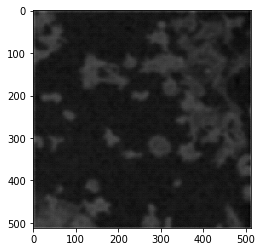

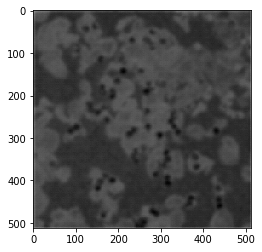

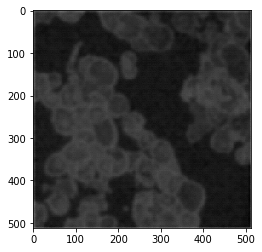

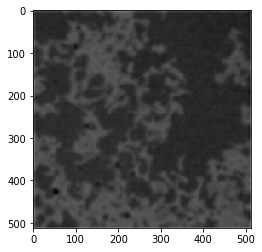

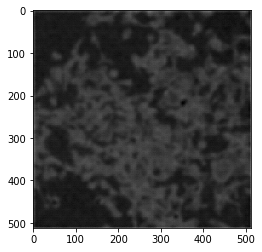

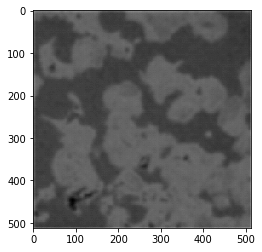

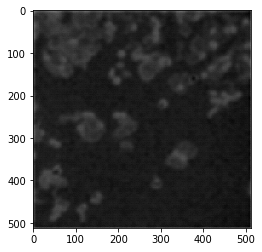

In [0]:
model.eval()
for i, X in enumerate(test_dl):
        output = model.cuda()(Variable(torch.FloatTensor(X)).cuda()).squeeze()
        im = output.cpu().detach().numpy()
        im = (255*im).astype(int)
        plt.imshow(im, 'gray')
        plt.show()